In [136]:
import pickle, torch, argparse
from fig_settings import * 
from tqdm.notebook import tqdm

from util import LossFunction
from m_encoder import *
from util import ViscoelasticDataset
from torch.utils.data import DataLoader, random_split, Subset

In [137]:
encoder_run_id = 'encoder_run_1'
params = torch.load(encoder_run_id+'/args.pkl', weights_only=True)
args = argparse.Namespace(**params)  

In [138]:
device = torch.device(args.device if torch.cuda.is_available() else "cpu")

with open(args.data_path, "rb") as f:
    data = pickle.load(f)


# N = args.n_samples
# step = args.step

# e = torch.tensor(data["strain"][:N, ::step], dtype=torch.float32).to(device)
# e_dot = torch.tensor(data["strain_rate"][:N, ::step], dtype=torch.float32).to(device)
# s = torch.tensor(data["stress"][:N, ::step], dtype=torch.float32).to(device)
# E = torch.tensor(data["E"][:N], dtype=torch.float32).to(device)
# nu = torch.tensor(data["nu"][:N], dtype=torch.float32).to(device)

In [139]:
dataset = ViscoelasticDataset(
    data_path=args.data_path, N=args.n_samples, step=args.step, device=args.device, encoder=True
)
indices = torch.load(f'{encoder_run_id}/dataset_indices.pth', weights_only=True)
trainset = Subset(dataset, indices["train_indices"])
valset = Subset(dataset, indices["val_indices"])


In [140]:
loss_function = LossFunction()
domain = torch.linspace(0, 1, 501)

ae_E = AutoEncoder(501, args.hidden_dim, args.latent_dim).to(device)
ae_nu = AutoEncoder(501, args.hidden_dim, args.latent_dim).to(device)

ae_E.load_state_dict(torch.load(f"{encoder_run_id}/ae_E.pth", weights_only=True, map_location=torch.device('cpu')))
ae_nu.load_state_dict(torch.load(f"{encoder_run_id}/ae_nu.pth", weights_only=True, map_location=torch.device('cpu')))

<All keys matched successfully>

In [141]:
val_E, val_nu = valset[0]
val_E_recon, val_nu_recon = ae_E(val_E.unsqueeze(0)), ae_nu(val_nu.unsqueeze(0))

train_E, train_nu = trainset[0]
train_E_recon, train_nu_recon = ae_E(train_E.unsqueeze(0)), ae_nu(train_nu.unsqueeze(0))

In [142]:
E_train = torch.stack([trainset[i][0] for i in range(len(trainset))], dim=0)
nu_train = torch.stack([trainset[i][1] for i in range(len(trainset))], dim=0)

E_val = torch.stack([valset[i][0] for i in range(len(valset))], dim=0)
nu_val = torch.stack([valset[i][1] for i in range(len(valset))], dim=0)

In [143]:
E_recon_train = ae_E(E_train).detach()
nu_recon_train = ae_nu(nu_train).detach()
E_recon_val = ae_E(E_val).detach()
nu_recon_val = ae_nu(nu_val).detach()


In [144]:
E_train_loss = loss_function.L2RelativeError(E_recon_train.unsqueeze(-1), E_train.unsqueeze(-1), reduction=None)
nu_train_loss = loss_function.L2RelativeError(nu_recon_train.unsqueeze(-1), nu_train.unsqueeze(-1), reduction=None)

E_val_loss = loss_function.L2RelativeError(E_recon_val.unsqueeze(-1), E_val.unsqueeze(-1), reduction=None)
nu_val_loss = loss_function.L2RelativeError(nu_recon_val.unsqueeze(-1), nu_val.unsqueeze(-1), reduction=None)

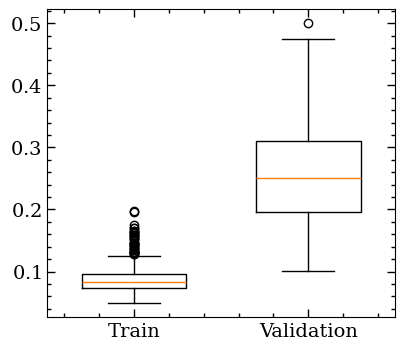

In [145]:
plt.boxplot([E_train_loss.cpu().numpy(), E_val_loss.cpu().numpy()], positions=[1, 2], widths=0.6)
plt.xticks([1, 2], ['Train', 'Validation'])
plt.show()

In [151]:
E_val.shape, E_recon_val.shape

(torch.Size([200, 501]), torch.Size([200, 501]))

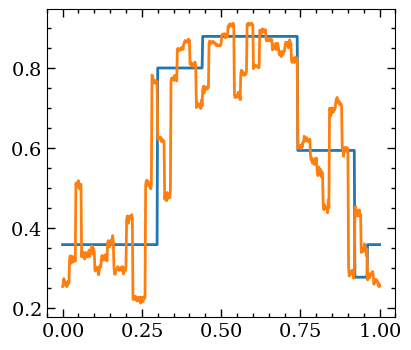

In [162]:
id = 17
plt.plot(domain.cpu(), E_val[id].cpu(), label='True')
plt.plot(domain.cpu(), E_recon_val[id].cpu().numpy(), label='Reconstructed')

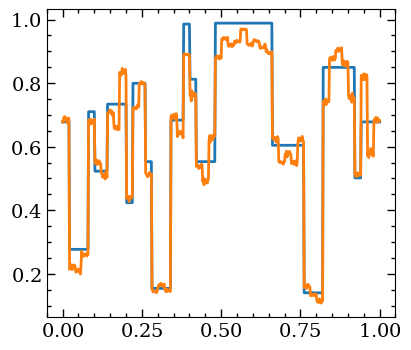

In [157]:
id = 11
plt.plot(domain.cpu(), E_train[id].cpu(), label='True')
plt.plot(domain.cpu(), E_recon_train[id].cpu().numpy(), label='Reconstructed')

In [95]:
print(type(trainset[0][1][1][1]))
len(trainset[0][0])

<class 'torch.Tensor'>


TypeError: object of type 'int' has no len()

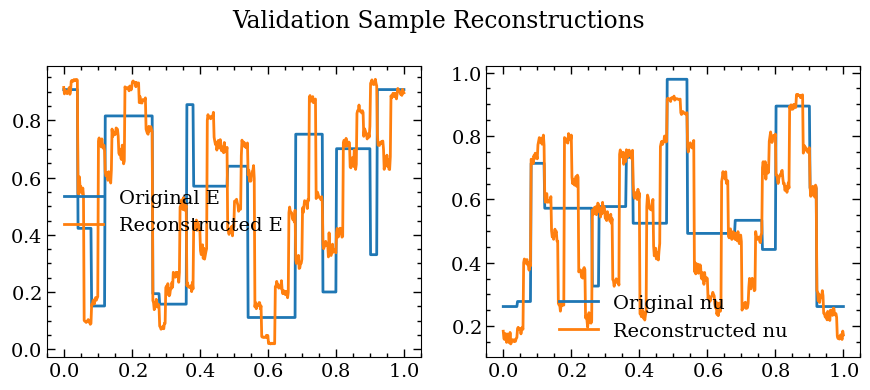

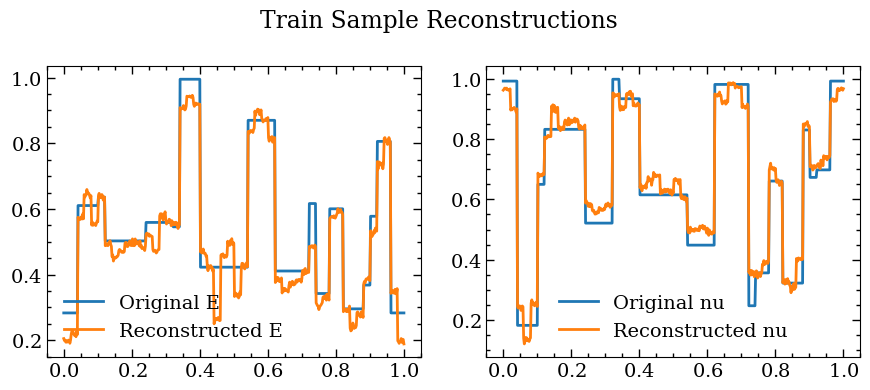

In [163]:
fig = plt.figure(figsize=(9,4))
plt.subplot(1, 2,1)
plt.plot(domain, val_E.cpu().numpy().flatten(), label='Original E')
plt.plot(domain, val_E_recon.detach().cpu().numpy().flatten(), label='Reconstructed E')
plt.legend()


plt.subplot(1, 2,2)
plt.plot(domain, val_nu.cpu().numpy().flatten(), label='Original nu')
plt.plot(domain, val_nu_recon.detach().cpu().numpy().flatten(), label='Reconstructed nu')
plt.legend()
fig.suptitle('Validation Sample Reconstructions')
plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(9,4))
plt.subplot(1, 2,1)
plt.plot(domain, train_E.cpu().numpy().flatten(), label='Original E')
plt.plot(domain, train_E_recon.detach().cpu().numpy().flatten(), label='Reconstructed E')
plt.legend()


plt.subplot(1, 2,2)
plt.plot(domain, train_nu.cpu().numpy().flatten(), label='Original nu')
plt.plot(domain, train_nu_recon.detach().cpu().numpy().flatten(), label='Reconstructed nu')
plt.legend()
fig.suptitle('Train Sample Reconstructions')
plt.tight_layout()
plt.show()


In [164]:
# Combine Pickle Data Files
files = [
        '2024-10-13_PC1D_process10_data.pkl',
        '2024-10-13_PC1D_process11_data.pkl',
        '2024-10-13_PC1D_process12_data.pkl'
        ]

In [167]:
dataset = ViscoelasticDataset(
    data_path=args.data_path,
    N=args.n_samples,
    step=args.step,
    device=device,
    encoder=True,
)

1000

In [ ]:
files = ['']